In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files

In [ ]:
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

In [2]:
import pandas as pd
import numpy as np
from keras.layers import Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.utils import np_utils
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from datetime import datetime
import pickle

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# tf.debugging.set_log_device_placement(True)

In [ ]:
data = pd.read_json('/content/drive/My Drive/Master Thesis/Data/train_test_2005_2018_cleaned.json')

In [ ]:
uos = RandomUnderSampler(random_state=45)
data_x, data_y = uos.fit_resample(np.array(data['cleaned_text']).reshape(-1,1),np.array(data['stars']).reshape(-1,1))
data_us = pd.DataFrame(list(zip([x[0] for x in data_x], data_y)), columns = ['cleaned_text', 'stars'])

In [ ]:
data_us.stars.value_counts()
#data_us.head(1)

1    204237
2    204237
3    204237
4    204237
5    204237
Name: stars, dtype: int64

In [ ]:
data_us['stars_reduce'] = data_us['stars']-1

In [ ]:
dummy_y = np_utils.to_categorical(data_us.stars_reduce)
dummy_y.shape

(1021185, 5)

In [ ]:
X_train, X_test,Y_train, Y_test = train_test_split(data_us.cleaned_text, dummy_y, test_size=0.2, random_state = 45)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

#words_to_index is the dictionary mapping words to their respective index.
words_to_index = tokenizer.word_index

In [ ]:
# saving
with open('/content/drive/My Drive/Master Thesis/Model/keras_cnn_tokenizer_2005_2018.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
maxLen = 300
vocab_len = len(words_to_index) +1
embedding_dim = 64

In [ ]:
def conv1d_model(input_shape):

  X_indices = Input(input_shape)

  embeddings = Embedding(input_dim=vocab_len, output_dim=embedding_dim, input_length=maxLen)(X_indices)

  X = Conv1D(256,3,activation='relu')(embeddings)
  X = Dropout(0.5)(X)
  
  X = Conv1D(128,3,activation='relu')(X)
  X = Dropout(0.5)(X)

  X = Conv1D(128,3,activation='relu')(X)
  X = Dropout(0.5)(X)

  X = Conv1D(128,3,activation='relu')(X)
  X = Dropout(0.5)(X)

  X = GlobalMaxPooling1D()(X)

  X = Dense(128, activation='relu')(X)
  X = Dense(5, activation='softmax')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [ ]:
model = conv1d_model((maxLen,))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 64)           11288192  
                                                                 
 conv1d (Conv1D)             (None, 298, 256)          49408     
                                                                 
 dropout (Dropout)           (None, 298, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 296, 128)          98432     
                                                                 
 dropout_1 (Dropout)         (None, 296, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 294, 128)          49280 

In [ ]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')

print(X_train_indices.shape)

X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

(816948, 300)


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 5e-5)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
callback = EarlyStopping(monitor='val_loss', patience=2)
epochs = 20

In [ ]:
start_time = datetime.now()
history = model.fit(X_train_indices, Y_train, validation_data=(X_test_indices, np.asarray(Y_test)), batch_size=64, epochs=epochs, callbacks=[callback])
end_time = datetime.now()
print('--- Duration ---{}'.format(end_time - start_time))

Epoch 1/20
12765/12765 [==============================] - 327s 25ms/step - loss: 1.1163 - accuracy: 0.4854 - val_loss: 1.2413 - val_accuracy: 0.5118
Epoch 2/20
12765/12765 [==============================] - 316s 25ms/step - loss: 0.9189 - accuracy: 0.5911 - val_loss: 1.2602 - val_accuracy: 0.5113
Epoch 3/20
12765/12765 [==============================] - 316s 25ms/step - loss: 0.8801 - accuracy: 0.6098 - val_loss: 1.2257 - val_accuracy: 0.5255
Epoch 4/20
12765/12765 [==============================] - 319s 25ms/step - loss: 0.8583 - accuracy: 0.6207 - val_loss: 1.1985 - val_accuracy: 0.5122
Epoch 5/20
12765/12765 [==============================] - 319s 25ms/step - loss: 0.8409 - accuracy: 0.6292 - val_loss: 1.1879 - val_accuracy: 0.5025
Epoch 6/20
12765/12765 [==============================] - 320s 25ms/step - loss: 0.8265 - accuracy: 0.6369 - val_loss: 1.1681 - val_accuracy: 0.5159
Epoch 7/20
12765/12765 [==============================] - 318s 25ms/step - loss: 0.8136 - accuracy: 0.6439

In [ ]:
model.evaluate(X_test_indices, Y_test)

6383/6383 [==============================] - 29s 4ms/step - loss: 1.0078 - accuracy: 0.5702


[1.007750153541565, 0.5702345967292786]

Text(0.5, 1.0, 'Accuracy')

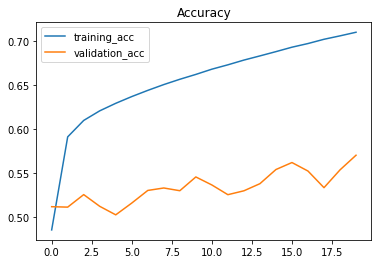

In [ ]:
#plot accuracy
#plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

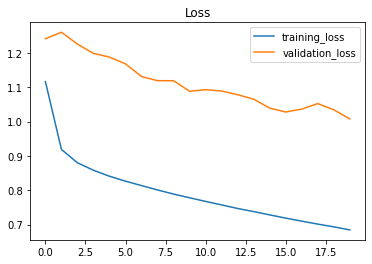

In [ ]:
#plot loss
#plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['loss'])
plt.plot(range(epochs), history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss')

In [ ]:
model.save('/content/drive/My Drive/Master Thesis/Model/keras_cnn_2015_2018')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Master Thesis/Model/keras_cnn_2015_2018/assets


In [4]:
loaded_model = keras.models.load_model('/content/drive/My Drive/Master Thesis/Model/keras_cnn_2015_2018')

In [ ]:
np.testing.assert_allclose(
    model.predict(X_test_indices), loaded_model.predict(X_test_indices)
)

In [15]:
data_test = pd.read_json('/content/drive/My Drive/Master Thesis/Data/restaurant_review_2019_cleaned_deep_prediction.json')

In [7]:
# loading tokenizer
with open('/content/drive/My Drive/Master Thesis/Model/keras_cnn_tokenizer_2005_2018.pickle', 'rb') as handle:
    keras_tokenizer = pickle.load(handle)

In [8]:
maxLen = 300
test_indices = keras_tokenizer.texts_to_sequences(data_test.cleaned_text)
test_indices = pad_sequences(test_indices, maxlen=maxLen, padding='post')

print(test_indices.shape)

(524593, 300)


In [9]:
preds = loaded_model.predict(test_indices)

In [10]:
star_pred = np.argmax(preds, axis=1)+1

In [11]:
confusion_matrix(data_test.stars, star_pred)

array([[ 38196,  22580,   6187,    756,    685],
       [  4973,  19256,  14569,    862,    293],
       [  1140,   6757,  35447,   6427,    877],
       [   306,    805,  23330,  58241,  18634],
       [   695,    702,   8672,  81991, 172212]])

In [12]:
print(classification_report(data_test.stars, star_pred))

              precision    recall  f1-score   support

           1       0.84      0.56      0.67     68404
           2       0.38      0.48      0.43     39953
           3       0.40      0.70      0.51     50648
           4       0.39      0.57      0.47    101316
           5       0.89      0.65      0.75    264272

    accuracy                           0.62    524593
   macro avg       0.58      0.59      0.57    524593
weighted avg       0.70      0.62      0.64    524593



In [16]:
data_test['stars_keras_cnn'] = star_pred

In [17]:
data_test.head(1)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,restaurant,...,postal_code,latitude,longitude,average_stars,review_count,categories,year,cleaned_text,stars_keras_lstm,stars_keras_cnn
48,WglA0BSYvc3WBP4I2WpRwA,1_sws6Q8TiR21CzzNvxUiw,XQfwVwDr-v0ZS3_CbbE5Xw,5,0,0,0,I've been here now twice for brunch and the fo...,2019-04-15 01:20:23,Turning Point of North Wales,...,19454,40.210196,-75.223639,3.0,169,"Restaurants, Breakfast & Brunch, Food, Juice B...",2019,I 've be here now twice for brunch and the foo...,5,4


In [18]:
# data_test.to_json('/content/drive/My Drive/Master Thesis/Data/restaurant_review_2019_cleaned_deep_prediction.json')